In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Position Correction functions

In [69]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy.signal import correlate
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial

def update_beta(positions1,positions2, beta):
        
    k = correlate(positions1,positions2)
    
    threshold1 = +0.3
    threshold2 = -0.3
    
    if k > threshold1:
        beta = beta*1.1 # increase by 10%
    elif k < threshold2:
        beta = beta*0.9 #reduce by 10%
    else:
        pass # keep same value
    
    return beta

def get_illuminated_mask(probe,probe_threshold):
    mask = np.where(probe > np.max(probe)*probe_threhsold, 1, 0)
    return mask

def correct_position(probe, probe_threshold, upsampling, beta, data):
    
    obj,previous_obj, position, posiiton, index = data # unpack inputs that vary
    
    illumination_mask = get_binary_mask(probe,probe_threshold)
    
    obj = obj*illumination_mask
    previous_obj = previous_obj*illumination_mask
                         
    relative_shift, error, diffphase = phase_cross_correlation(obj, previous_obj, upsample_factor=upsampling)
    
    new_position = position + beta*relative_shift
    
    return new_position, index

def position_correction(obj,previous_obj,positions, beta, probe_threshold=0.1, upsampling=100):

    indexes = np.linspace(0,obj.shape[0]-1,obj.shape[0])
    list_of_inputs = list(zip(obj,previous_obj,positions,indexes))
    
    correct_position_partial = partial(correct_position,probe, probe_threshold, upsampling, beta)
    
    new_positions = np.zeros_like(positions)
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(correct_position,list_of_inputs),total=positions.shape[0]))
        for result in results:
            position, index = result
            new_positions[index] = position
            
    return new_positions
    

## Ptycho functions

In [72]:
import numpy as np
import cupy as cp
import h5py

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import datetime
import time

from PIL import Image

from sscPimega import misc

import random
random.seed(0)

from ptycho_functions import *

def plot_results3(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time ):
    colormap = 'jet'    
    figure, ax = plt.subplots(5,5,dpi=150,figsize=(15,10))
    count = -1
    for i,ax0 in enumerate(ax.reshape(-1)):
        count += 1
        if count == 5: 
            ax0.grid()
            continue
        ax0.set_yticks([])
        ax0.set_xticks([])
    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
    ax[0,0].set_title("Sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,1].set_title("Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap=colormap)
    ax[0,2].set_title("Phase")
    ax[0,3].imshow(np.abs(probe_guess),cmap=colormap)
    ax[0,3].set_title("Magnitude")
    ax[0,4].imshow(np.angle(probe_guess),cmap=colormap)
    ax[0,4].set_title("Phase")
    
    ax[0,0].set_ylabel('Model')
    ax[1,0].set_ylabel('RAAR')
    ax[2,0].set_ylabel('mPIE')
    ax[3,0].set_ylabel('mPIE multi')
    ax[4,0].set_ylabel('RAAR multi')
    
    ax[1,0].plot(RAAR_error,'.-',label='RAAR')
    ax[1,0].plot(PIE_error,'.-',label='PIE')
    ax[1,0].plot(PIE2_error,'.-',label='PIE-multi')
    ax[1,0].plot(RAAR2_error,'.-',label='RAAR-multi')
    
    ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
    ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap)
    ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
    ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap)

    
    crop = 25        
    ax[2,0].imshow(np.abs(RAAR2_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[2,1].imshow(np.abs(RAAR2_obj),cmap=colormap)
    ax[2,2].imshow(np.angle(RAAR2_obj),cmap=colormap)
    ax[2,3].imshow(np.abs(RAAR2_probe),cmap=colormap)
    ax[2,4].imshow(np.angle(RAAR2_probe),cmap=colormap)    
    
    
    ax[3,0].imshow(np.abs(PIE_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[3,1].imshow(np.abs(PIE_obj),cmap=colormap)
    ax[3,2].imshow(np.angle(PIE_obj),cmap=colormap)
    ax[3,3].imshow(np.abs(PIE_probe),cmap=colormap)
    ax[3,4].imshow(np.angle(PIE_probe),cmap=colormap)

    
    ax[4,0].imshow(np.abs(PIE2_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[4,1].imshow(np.abs(PIE2_obj),cmap=colormap)
    ax[4,2].imshow(np.angle(PIE2_obj),cmap=colormap)
    ax[4,3].imshow(np.abs(PIE2_probe),cmap=colormap)
    ax[4,4].imshow(np.angle(PIE2_probe),cmap=colormap)    


    ax[1,0].legend()
    figure.tight_layout()
    
def plot_results2(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time):
    colormap = 'jet'    
    figure, ax = plt.subplots(4,5,dpi=150,figsize=(15,10))
    count = -1
    for i,ax0 in enumerate(ax.reshape(-1)):
        count += 1
        if count == 5: 
            ax0.grid()
            continue
        ax0.set_yticks([])
        ax0.set_xticks([])
    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
    ax[0,0].set_title("Sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,1].set_title("Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap=colormap)
    ax[0,2].set_title("Phase")
    ax[0,3].imshow(np.abs(probe_guess),cmap=colormap)
    ax[0,3].set_title("Magnitude")
    ax[0,4].imshow(np.angle(probe_guess),cmap=colormap)
    ax[0,4].set_title("Phase")
    ax[1,0].plot(RAAR_error,'.-',label='RAAR')
    ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
    ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap)
    ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
    ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap)
    ax[0,0].set_ylabel('Model')
    ax[1,0].set_ylabel('RAAR')
    ax[2,0].set_ylabel('mPIE')
    ax[3,0].set_ylabel('mPIE multi')
    ax[1,0].plot(PIE_error,'.-',label='PIE')
    ax[2,1].imshow(np.abs(PIE_obj),cmap=colormap)
    crop = 25
    ax[2,0].imshow(np.abs(PIE_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[2,2].imshow(np.angle(PIE_obj),cmap=colormap)
    ax[2,3].imshow(np.abs(PIE_probe),cmap=colormap)
    ax[2,4].imshow(np.angle(PIE_probe),cmap=colormap)

    
    ax[1,0].plot(PIE2_error,'.-',label='PIE-multi')
    ax[3,0].imshow(np.abs(PIE2_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[3,1].imshow(np.abs(PIE2_obj),cmap=colormap)
    ax[3,2].imshow(np.angle(PIE2_obj),cmap=colormap)
    ax[3,3].imshow(np.abs(PIE2_probe),cmap=colormap)
    ax[3,4].imshow(np.angle(PIE2_probe),cmap=colormap)    

    ax[1,0].legend()
    figure.tight_layout()

def calculate_probe_relative_power(probes):
    mode_power = []

    total_power = 0
    for m in range(probes.shape[0]):
        total_power += np.sum(np.abs(probes[m])**2)

    for m in range(probes.shape[0]):
        mode_power.append(np.sum(np.abs(probes[m])**2)/total_power)

    return mode_power
    
def plot_probe_modes(probes):
    n_probes = probes.shape[0]
    mode_power = calculate_probe_relative_power(probes)
    
    figure, axes = plt.subplots(2,n_probes,figsize=(20,5))
    if len(axes.shape) > 1:
        for column in range(axes.shape[1]):
            axes[0,column].imshow(np.abs(probes[column]),cmap='jet')
            axes[1,column].imshow(np.angle(probes[column]),cmap='jet')
            axes[0,column].set_title(f"{100*mode_power[column]:.2f}%")
        axes[0,0].set_ylabel(f"Magnitude")
        axes[1,0].set_ylabel(f"Phase")
    else:
        for column in range(axes.shape[0]):
            print(column,axes.shape)
            axes[column].imshow(np.abs(probes[0]),cmap='jet')
            axes[column].imshow(np.angle(probes[0]),cmap='jet')
            axes[column].set_title(f"{100*mode_power[0]:.2f}%")
        axes[0].set_ylabel(f"Magnitude")
        axes[1].set_ylabel(f"Phase")    
           
    for ax in axes.flatten(): 
        ax.set_xticks([]), ax.set_yticks([])
    figure.tight_layout()

def get_denominator_p(obj,reg_p,algo='rPIE'):
    
    power = np.abs(obj)**2
    
    if algo == 'rPIE':
        denominator = (1-reg_p)*power+ reg_p*np.max(power)
    elif algo == 'ePIE':
        pass
    
    return denominator  

def get_denominator_o(probe_modes,reg_o,algo='rPIE'):
    
    total_probe_power = np.zeros_like(np.abs(probe_modes[0]))
    for mode in probe_modes:
        total_probe_power += np.abs(mode)**2    
        
    if algo == 'rPIE':
        denominator = (1-reg_o)*total_probe_power + reg_o*np.max(total_probe_power)
    elif algo == 'ePIE':
        pass
    
    return denominator  

def PIE_update_func_multiprobe(obj,probe_modes,wavefront_modes,updated_wavefront_modes,s_o=1,s_p=1,r_o=0.1,r_p=0.1,algo='rPIE'):

    """ 
    s: step constant
    r: regularization constant
    """
    
    # Pre-calculating to avoid repeated operations
    denominator_object = get_denominator_o(probe_modes,r_o,algo)
    probe_modes_conj = probe_modes.conj()
    Delta_wavefront_modes =  updated_wavefront_modes - wavefront_modes

    if algo == 'rPIE':

        obj = obj + s_o * np.sum(probe_modes_conj*Delta_wavefront_modes,axis=0) / denominator_object # object update
        
        obj_conj = obj.conj()
        denominator_probe  = get_denominator_p(obj,r_p)

        for m in range(probe_modes.shape[0]): # P_(i+1) = P_(i) + s_p * DeltaP_(i)
            probe_modes[m] = probe_modes[m] + s_p * obj_conj*Delta_wavefront_modes[m] / denominator_probe # probe update
        
    return obj, probe_modes


def Fspace_update_multiprobe(wavefront_modes,DP_magnitude,epsilon=0.01):
    
    total_wave_intensity = np.zeros_like(wavefront_modes[0])

    for mode in wavefront_modes:
        total_wave_intensity += np.abs(mode)**2
    total_wave_intensity = np.sqrt(total_wave_intensity)
    
    updated_wavefront_modes = np.zeros_like(wavefront_modes,dtype=complex)
    for m, mode in enumerate(wavefront_modes): #TODO: worth updating in parallel?
        #TODO: update only where difpad is valid
        updated_wavefront_modes[m] = DP_magnitude*mode/(total_wave_intensity+epsilon)
    
    return updated_wavefront_modes
    
from numpy.fft import fft2, fftshift, ifftshift, ifft2 
def propagate_farfield_multiprobe(wavefront_modes,backpropagate=False):
    if backpropagate == False:
        for m, mode in enumerate(wavefront_modes): #TODO: worth propagating in parallel?
            wavefront_modes[m] = fftshift(fft2(fftshift(mode)))
    else:
        for m in range(wavefront_modes.shape[0]): #TODO: worth propagating in parallel?
            wavefront_modes[m] = ifftshift(ifft2(ifftshift(wavefront_modes[m])))
    return wavefront_modes


def update_exit_wave_multiprobe(wavefront_modes,DP_magnitude):
    wavefront_modes = propagate_farfield_multiprobe(wavefront_modes)
    wavefront_modes = Fspace_update_multiprobe(wavefront_modes,DP_magnitude)
    updated_wavefront_modes = propagate_farfield_multiprobe(wavefront_modes,backpropagate=True)
    return updated_wavefront_modes

def momentum_addition_multiprobe(momentum_counter,m_counter_limit,probe_velocity,obj_velocity,O_aux,P_aux,obj,probe,friction_object,friction_probe,momentum_type=""):
    
    momentum_counter += 1    
    if momentum_counter == m_counter_limit : 

        probe_velocity = friction_probe*probe_velocity + (probe - P_aux) # equation 19 in the paper
        obj_velocity   = friction_object*obj_velocity  + (obj - O_aux)  

        if momentum_type == "Nesterov": # equation 21
            obj = obj + friction_object*obj_velocity
            probe = probe + friction_object*probe_velocity 
        else: # equation 20     
            obj = O_aux + obj_velocity
            probe = P_aux + probe_velocity 

        O_aux = obj
        P_aux = probe            
        momentum_counter = 0
    
    return momentum_counter,obj_velocity,probe_velocity,O_aux,P_aux,obj,probe


""" MAIN LOOPS """

def RAAR_loop(diffractions_patterns,positions,obj,probe,RAAR_params,experiment_params, iterations,model):
    t0 = time.perf_counter()
    print("Starting RAAR...")
    
    beta, epsilon = RAAR_params
    dx, wavelength,distance = experiment_params 
    shapey,shapex = probe.shape
    wavefronts = np.zeros((len(positions),probe.shape[0],probe.shape[1]),dtype=complex)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        obj_box = obj[posy:posy + shapey , posx:posx+ shapex]
        wavefronts[index] = probe*obj_box

    error = []
    for iteration in range(0,iterations):
        """
        RAAR update function:
        psi' = [ beta*(Pf*Rr + I) + (1-2*beta)*Pr ]*psi
        psi' = beta*(Pf*Rr + I)*psi    + (1-2*beta)*Pr*psi
        psi' = beta*(Pf*(2*Pr-I)*psi   + (1-2*beta)*Pr*psi
        psi' = beta*(Pf*(2*Pr*psi-psi) + (1-2*beta)*Pr*psi
        """
        if iteration%10 ==0 : print(f'\tIteration {iteration}/{iterations}')

        for index in range(len(positions)): 
            pos = positions[index]
            posy, posx = pos[0], pos[1]
            obj_box = obj[posy:posy + shapey , posx:posx+ shapex]
            
            psi_after_Pr = probe*obj_box
            
            psi_after_reflection_Rspace = 2*psi_after_Pr-wavefronts[index]
            psi_after_projection_Fspace = update_exit_wave(psi_after_reflection_Rspace,diffractions_patterns[index],experiment_params,epsilon=epsilon) # Projection in Fourier space
            
            wavefronts[index] = beta*(wavefronts[index] + psi_after_projection_Fspace) + (1-2*beta)*psi_after_Pr 

        probe, obj = projection_Rspace_RAAR(wavefronts,obj,probe,positions,epsilon)# Projection in Real space (consistency condition)

        error.append(calculate_recon_error(model,obj)) #absolute error
    return obj, probe, error, time.perf_counter()-t0

def RAAR_multiprobe_loop(diffractions_patterns,positions,obj,probe,RAAR_params,experiment_params, iterations,model,n_of_modes = 1):
    t0 = time.perf_counter()
    print("Starting RAAR...")
    
    beta, epsilon = RAAR_params
    dx, wavelength,distance = experiment_params 

    obj_matrix = np.ones((n_of_modes,obj.shape[0],obj.shape[1]),dtype=complex) 
    obj_matrix[:] = obj # create matrix of repeated object to facilitate slice-wise product with probe modes
    
    shapey,shapex = probe.shape
    wavefronts = np.ones((len(positions),n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex) # wavefronts contain the wavefront for each probe mode, and for all probe positions
    
    if probe is None:
        probe_modes = np.ones((n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
    else:
        probe_modes = np.ones((n_of_modes,probe.shape[0],probe.shape[1]),dtype=complex)
        probe_modes[:] = probe
    
    for index, (posy, posx) in enumerate((positions)):
        obj_box = obj_matrix[:,posy:posy + shapey , posx:posx+ shapex]
        wavefronts[index] = probe_modes*obj_box

    DP_magnitudes = np.sqrt(diffractions_patterns)
        
    error = []
    for iteration in range(0,iterations):
        if iteration%10 ==0 : print(f'\tIteration {iteration}/{iterations}')

        for index, (posy, posx) in enumerate(positions):
            
            obj_box = obj_matrix[:,posy:posy + shapey , posx:posx+ shapex]
            
            psi_after_Pr = probe_modes*obj_box
            
            psi_after_reflection_Rspace = 2*psi_after_Pr-wavefronts[index]
            psi_after_projection_Fspace = update_exit_wave_multiprobe(psi_after_reflection_Rspace.copy(),DP_magnitudes[index]) # Projection in Fourier space

            wavefronts[index] = beta*(wavefronts[index] + psi_after_projection_Fspace) + (1-2*beta)*psi_after_Pr 

        probe_modes, single_obj_box = projection_Rspace_multiprobe_RAAR(wavefronts,obj_matrix[0],probe_modes,positions,epsilon) # Update Object and Probe! Projection in Real space (consistency condition)
        obj_matrix[:] = single_obj_box # update all obj slices to be the same;
        
        error.append(calculate_recon_error(model,obj_matrix[0])) #absolute error
        
    dt = time.perf_counter() - t0
    print(f"RAAR algorithm ended in {dt} seconds")
    
    return obj_matrix[0], probe_modes, error, dt


def mPIE_loop(diffractions_patterns, positions,object_guess,probe_guess, mPIE_params,experiment_params, iterations,model_obj):
    t0 = time.perf_counter()
    print("\n\nStarting PIE...")
    
    mPIE = True
    use_rPIE_update_function = True
    
    _,_,_,_,eta_obj,eta_probe,T_lim = mPIE_params
    
    offset = probe_guess.shape
    probeVelocity = 0
    objVelocity = 0
    T_counter = 0

    obj = object_guess

    probe = probe_guess
    
    error_list = []
    for j in range(iterations):

        if j%20 ==0 : print(f'\tIteration {j}/{iterations}')
        error, O_aux, P_aux = 0, obj+0, probe+0

        for i in np.random.permutation(len(diffractions_patterns)):  
        # for i in range(len(diffractions_patterns)):  
            
            px, py = positions[:,1][i],  positions[:,0][i]

            measurement = diffractions_patterns[i]
            
            """ Exit wavefiled """
            exitWave = obj[py:py+offset[0],px:px+offset[1]]*probe

            """ Propagate + Update + Backpropagate """
            exitWaveNew = update_exit_wave(exitWave,measurement,experiment_params,epsilon=0.01)

            difference = exitWaveNew - exitWave

            obj, probe, single_obj_box = PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,use_rPIE_update_function)
            
            if mPIE == True: # momentum addition
                T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe = momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,eta_obj,eta_probe)
            
        error_list.append(calculate_recon_error(model_obj,obj)) #absolute error

    # probe = probe.get() # get from cupy to numpy
    # obj = obj.get()

    return obj, probe, error_list, time.perf_counter() - t0
          
    
def PIE_multiprobe_loop(diffractions_patterns, positions, iterations, parameters, model_obj, n_of_modes = 1, object_guess=None, probe_guess=None, use_momentum = False):
    t0 = time.perf_counter()
    print("\n\nStarting multiprobe PIE algorithm...")
    
    r_o = parameters["regularization_object"]
    r_p = parameters["regularization_probe"]
    s_o = parameters["step_object"]
    s_p = parameters["step_probe"]
    f_o = parameters["friction_object"]
    f_p = parameters["friction_probe"]
    m_counter_limit = parameters["momentum_counter"]
    
    offset = probe_guess.shape
    obj = np.ones((n_of_modes,object_guess.shape[0],object_guess.shape[1]),dtype=complex)
    obj[:] = object_guess # object matrix repeats for each slice; each slice will operate with a different probe mode

    if probe_guess is None:
        probe_modes = np.ones((n_of_modes,probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)
    else:
        probe_modes = np.ones((n_of_modes,probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)
        probe_modes[:] = probe_guess
    
    probe_velocity = np.zeros_like(probe_modes,dtype=complex)
    obj_velocity   = np.zeros_like(obj,dtype=complex)

    DP_magnitudes = np.sqrt(diffractions_patterns)
    
    momentum_counter = 0
    error_list = []
    for i in range(iterations):

        if i%20 == 0 : print(f'\tIteration {i}/{iterations}')
        
        temporary_obj, temporary_probe = obj.copy(), probe_modes.copy()
        
        for j in np.random.permutation(len(diffractions_patterns)):  
        # for j in range(len(diffractions_patterns)):
            
            px, py = positions[:,1][j],  positions[:,0][j]

            
            obj_box = obj[:,py:py+offset[0],px:px+offset[1]]
            
            """ Wavefront at object exit plane """
            wavefront_modes = obj_box*probe_modes

            """ Propagate + Update + Backpropagate """
            updated_wavefront_modes = update_exit_wave_multiprobe(wavefront_modes.copy(),DP_magnitudes[j]) #copy so it doesn't work as a pointer!
            
            single_obj_box, probe_modes = PIE_update_func_multiprobe(obj_box[0],probe_modes,wavefront_modes,updated_wavefront_modes,s_o,s_p,r_o,r_p)

            obj[:,py:py+offset[0],px:px+offset[1]] = single_obj_box
            
            if use_momentum == True: # momentum addition
                momentum_counter,obj_velocity,probe_velocity,temporary_obj,temporary_probe,single_obj_box,probe_modes = momentum_addition_multiprobe(momentum_counter,m_counter_limit,probe_velocity,obj_velocity,temporary_obj,temporary_probe,obj, probe_modes,f_o,f_p,momentum_type="")

        error_list.append(calculate_recon_error(model_obj,obj[0])) #absolute error

    dt = time.perf_counter() - t0
    print(f"PIE algorithm ended in {dt} seconds")
    
    return obj, probe_modes, error_list, dt

Object pixel size: 2.1962328634132057e-08
Oversampling:  2.108383548876678


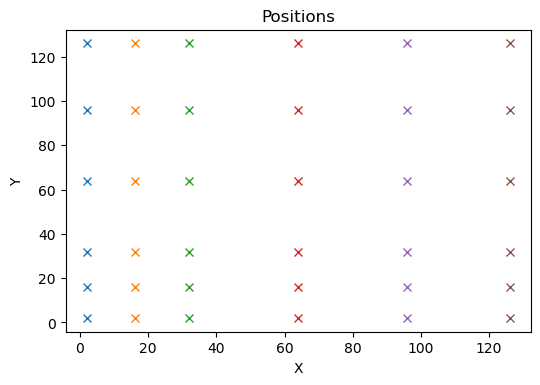

In [4]:
""" MAIN CODE """
    
difpads, positions, model_obj, model_probe, positions_errors = get_simulated_data(random_positions=False,add_position_errors=False)
probe_guess = model_probe*np.exp(-1j*model_probe*2)
obj_guess = np.ones_like(model_obj) # constant object
obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j

""" Experiment Parameters """
position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
distance = 30  # meters
energy = 10    # keV
n_pixels = 3072
pixel_size = 55.13e-6  # meters
c_speed = 299792458    # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
wavelength = c_speed * planck / energy
dx = wavelength*distance/(n_pixels*pixel_size)
experiment_params = dx, wavelength,distance
oversampling_ratio = wavelength*distance/(position_step*pixel_size)
print('Object pixel size:',dx)
print("Oversampling: ",oversampling_ratio)

iterations = 200
n_of_modes = 3

In [5]:
""" RAAR """
beta = 0.995
epsilon = 0.01
RAAR_params = (beta,epsilon)
RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(difpads,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)

Starting RAAR...
	Iteration 0/200
	Iteration 10/200
	Iteration 20/200
	Iteration 30/200
	Iteration 40/200
	Iteration 50/200
	Iteration 60/200
	Iteration 70/200
	Iteration 80/200
	Iteration 90/200
	Iteration 100/200
	Iteration 110/200
	Iteration 120/200
	Iteration 130/200
	Iteration 140/200
	Iteration 150/200
	Iteration 160/200
	Iteration 170/200
	Iteration 180/200
	Iteration 190/200


In [6]:
""" mPIE """
if 0: # suggested min from paper
    regularization_object, regularization_probe = 0.05, 0.5
    step_object, step_probe = 0.1, 0.2
    friction_object, friction_probe = 0.5, 0.75
    momentum_counter = 10
else: # suggested max from paper
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 1
    friction_object, friction_probe = 0.9, 0.99
    momentum_counter = 100 

mPIE_params = (regularization_object,regularization_probe,step_object,step_probe,friction_object,friction_probe,momentum_counter)
PIE_obj, PIE_probe, PIE_error, PIE_time = mPIE_loop(difpads, positions,obj_guess.copy(),probe_guess, mPIE_params, experiment_params, iterations, model_obj)



Starting PIE...
	Iteration 0/200
	Iteration 20/200
	Iteration 40/200
	Iteration 60/200
	Iteration 80/200
	Iteration 100/200
	Iteration 120/200
	Iteration 140/200
	Iteration 160/200
	Iteration 180/200


In [7]:
""" multiprobe RAAR """
beta = 0.995
epsilon = 0.01
RAAR_params = (beta,epsilon)
RAAR2_obj, RAAR2_probes, RAAR2_error, RAAR2_time = RAAR_multiprobe_loop(difpads,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj,n_of_modes=n_of_modes)
RAAR2_probe = RAAR2_probes[0]

Starting RAAR...
	Iteration 0/200
	Iteration 10/200
	Iteration 20/200
	Iteration 30/200
	Iteration 40/200
	Iteration 50/200
	Iteration 60/200
	Iteration 70/200
	Iteration 80/200
	Iteration 90/200
	Iteration 100/200
	Iteration 110/200
	Iteration 120/200
	Iteration 130/200
	Iteration 140/200
	Iteration 150/200
	Iteration 160/200
	Iteration 170/200
	Iteration 180/200
	Iteration 190/200
RAAR algorithm ended in 47.242989006015705 seconds


In [8]:
""" multiprobe mPIE """
mPIE_params = {}
mPIE_params["regularization_object"] = regularization_object
mPIE_params["regularization_probe"]  = regularization_probe
mPIE_params["step_object"]           = step_object
mPIE_params["step_probe"]            = step_probe
mPIE_params["friction_object"]       = friction_object
mPIE_params["friction_probe"]        = friction_probe
mPIE_params["momentum_counter"]      = momentum_counter
PIE2_obj, PIE2_multiprobe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(difpads, positions, iterations, mPIE_params, model_obj,n_of_modes = n_of_modes, object_guess=obj_guess.copy(), probe_guess=probe_guess, use_momentum = True)
PIE2_obj = PIE2_obj[0]
PIE2_probe = PIE2_multiprobe[0]



Starting multiprobe PIE algorithm...
	Iteration 0/200
	Iteration 20/200
	Iteration 40/200
	Iteration 60/200
	Iteration 80/200
	Iteration 100/200
	Iteration 120/200
	Iteration 140/200
	Iteration 160/200
	Iteration 180/200
PIE algorithm ended in 54.85719779500505 seconds


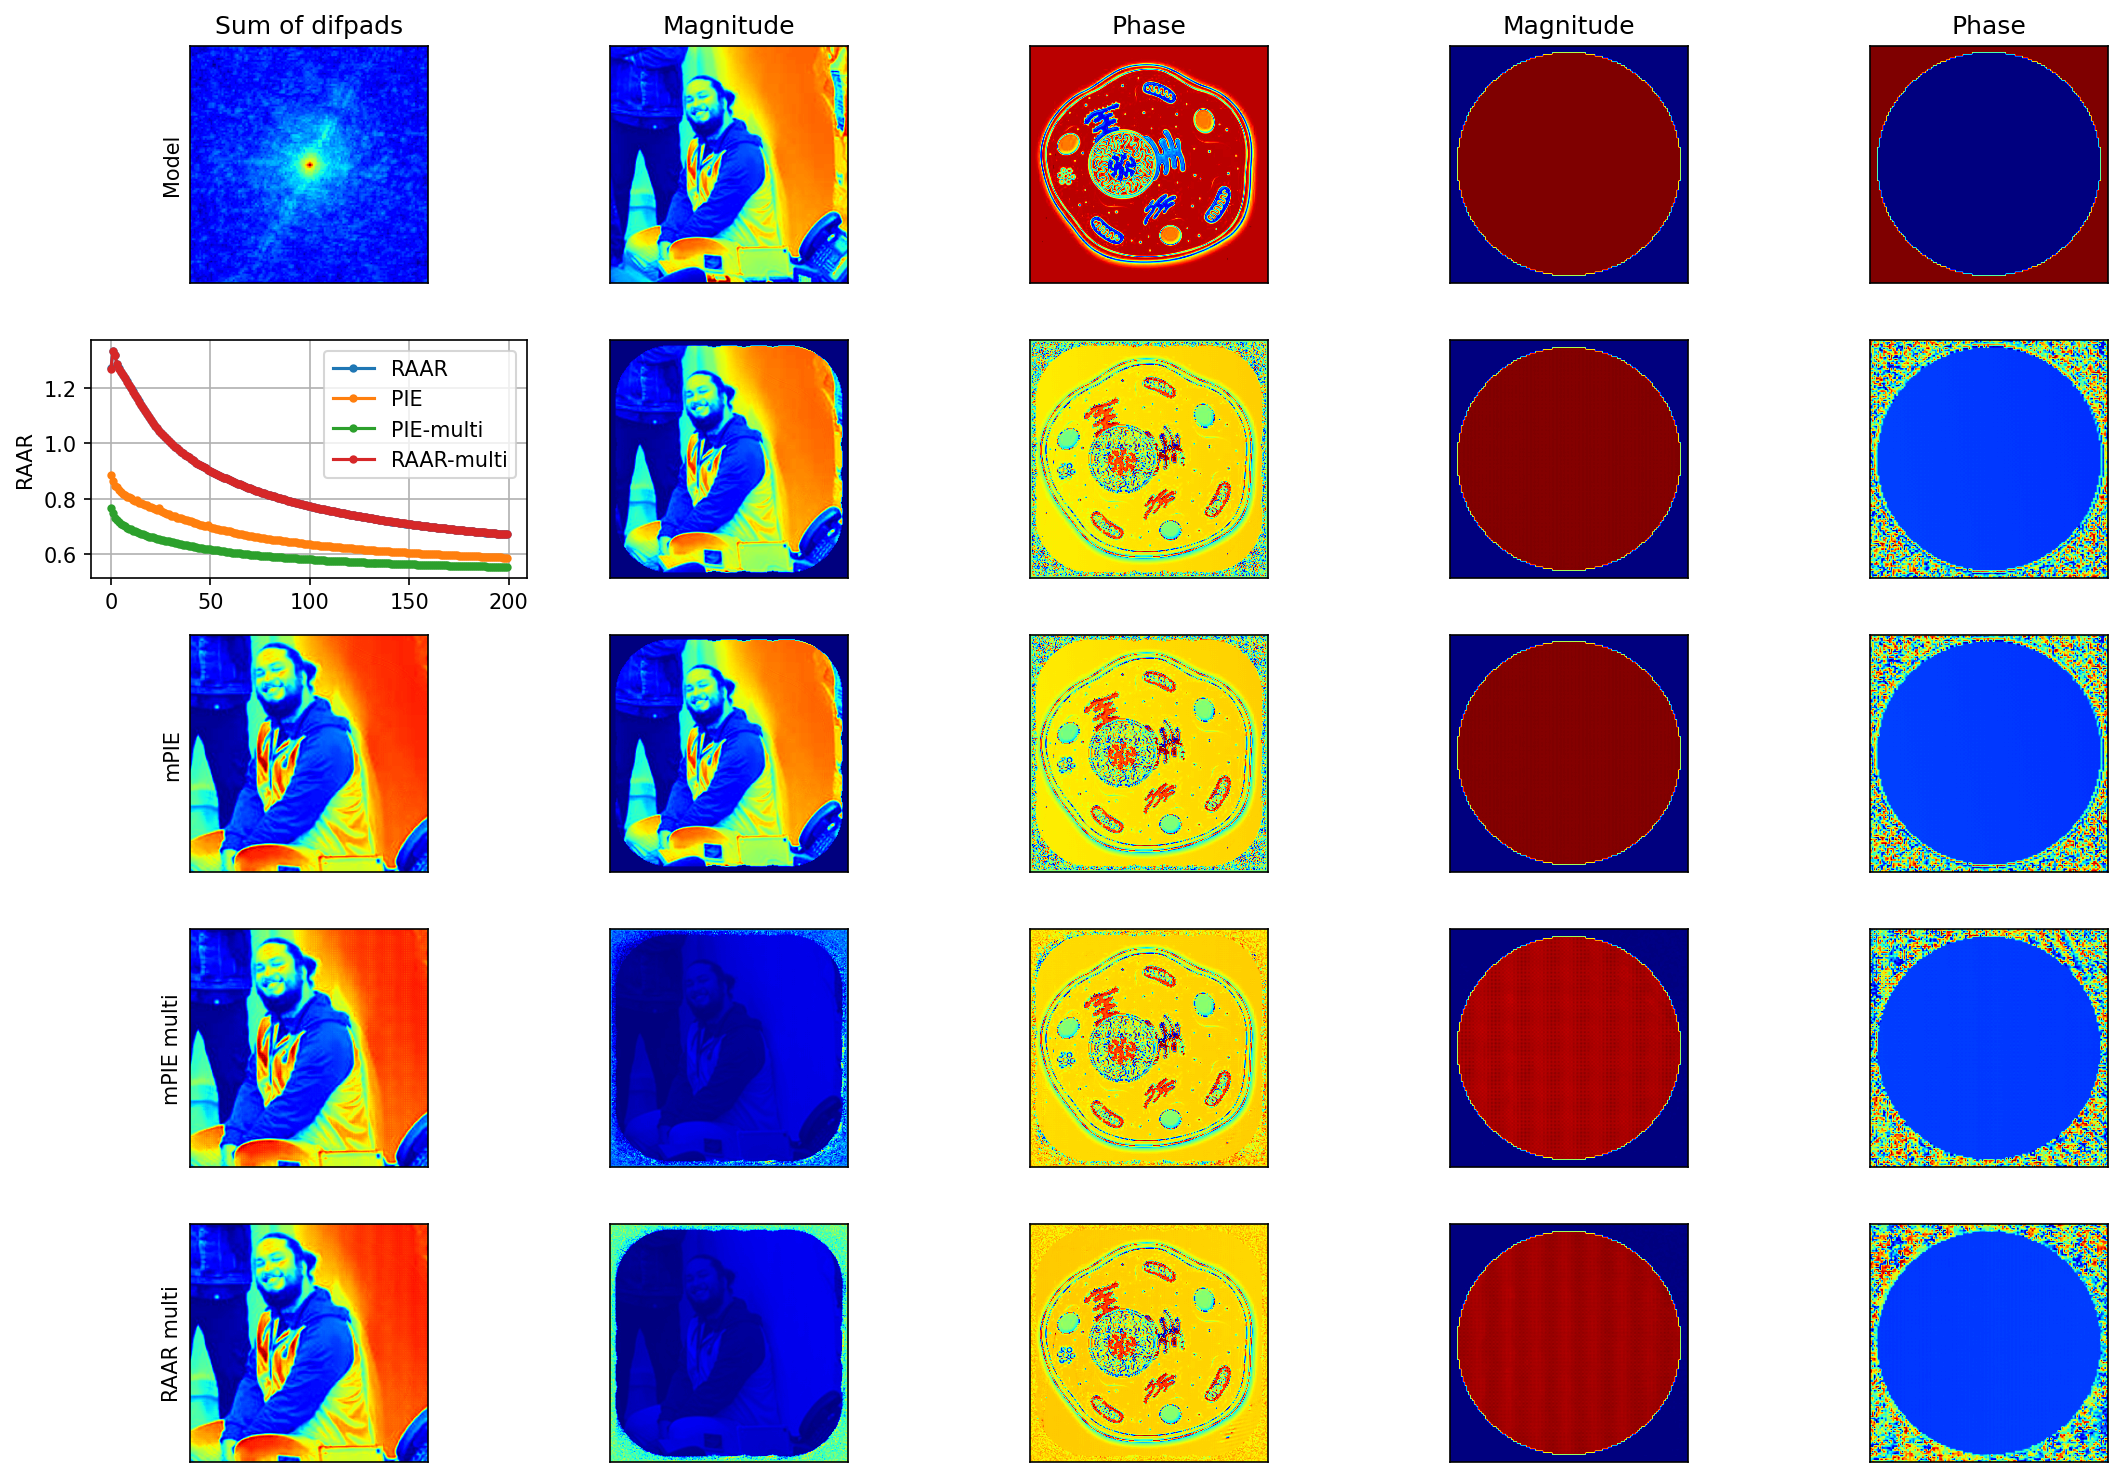

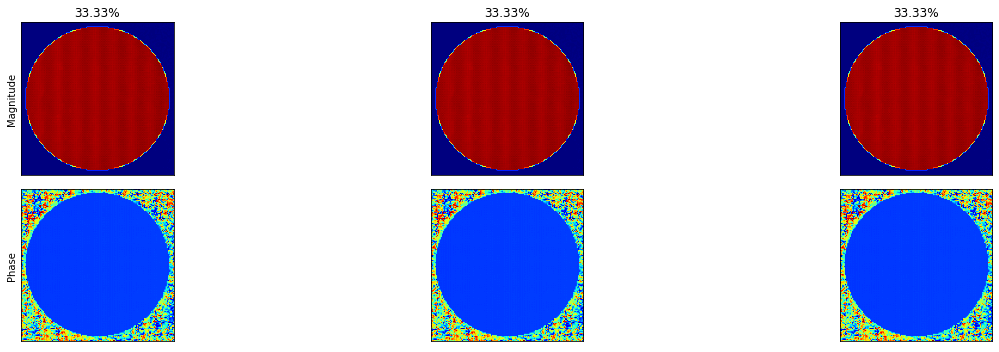

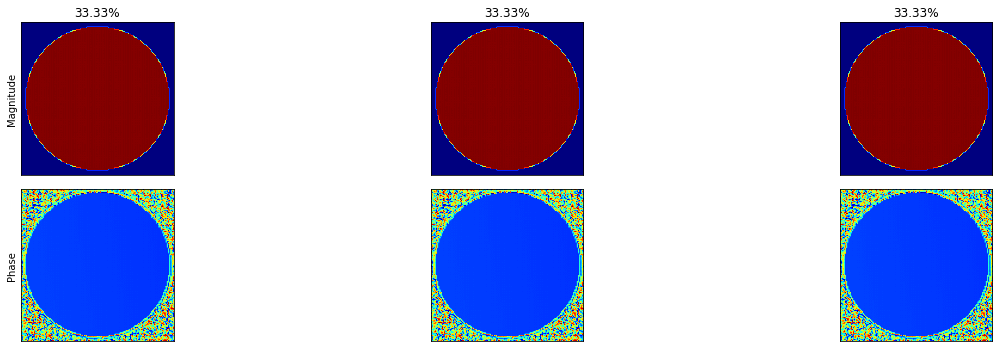

In [9]:
plot_results3(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time )
plot_probe_modes(PIE2_multiprobe)
plot_probe_modes(RAAR2_probes)

Saving data at:  /ibira/lnls/labs/tepui/proposals/20210062/yuri/data/caterete/00000000/data/ptycho3d/complex_phantom/images/flat.hdf5
Saving data at:  /ibira/lnls/labs/tepui/proposals/20210062/yuri/data/caterete/00000000/data/ptycho3d/complex_phantom/images/mask.hdf5
Saving data at:  /ibira/lnls/labs/tepui/proposals/20210062/yuri/data/caterete/00000000/data/ptycho3d/complex_phantom/images/empty.hdf5


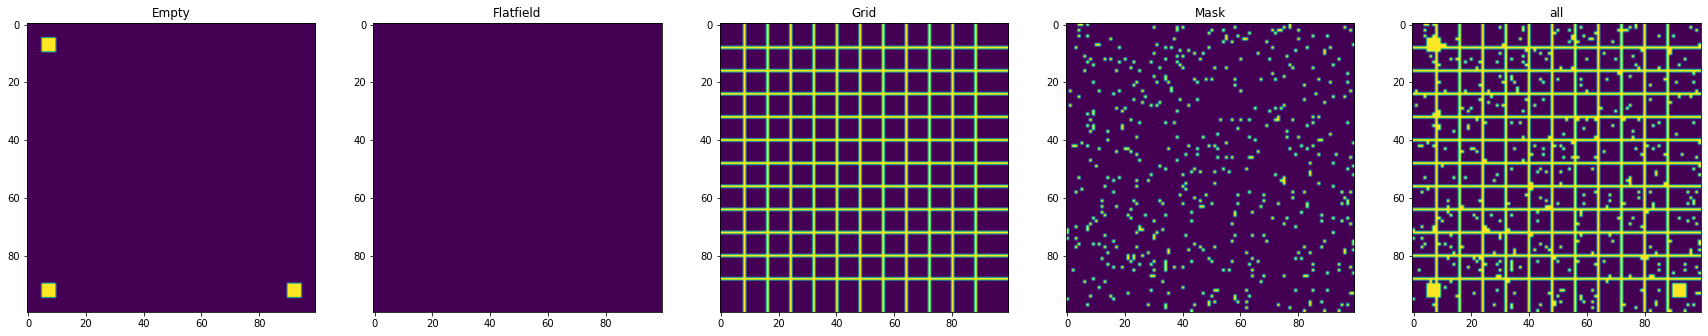

In [74]:


# N=100
# path = "/ibira/lnls/labs/tepui/proposals/20210062/yuri/data/caterete/00000000/data/ptycho3d/complex_phantom/"
# empty, flatfield, invalid_grid, invalid_points = create_correction_masks(N,N,path)

In [77]:
positions = [2,16,32,64,96,126]

positionsX,positionsY = np.meshgrid(positions,positions)

def apply_random_shifts_to_positions(positionsX,positionsY):
        mu, sigma = 0, 1 # mean and standard deviation
        deltaX = np.random.normal(mu, sigma, positionsX.shape)
        deltaY = np.random.normal(mu, sigma, positionsY.shape)
        return positionsX+deltaX,positionsY+deltaY 

apply_random_shifts_to_positions(positionsX,positionsY)

(array([[ 1.05070730e+00,  1.45907157e+01,  3.05768784e+01,
          6.30238782e+01,  9.60137940e+01,  1.25425343e+02],
        [ 1.34290119e+00,  1.75089007e+01,  3.36628255e+01,
          6.37223111e+01,  9.58462352e+01,  1.27256086e+02],
        [ 9.35090684e-01,  1.62071079e+01,  3.15234570e+01,
          6.29394594e+01,  9.56242653e+01,  1.25565175e+02],
        [ 1.31778125e+00,  1.61955293e+01,  3.08218996e+01,
          6.51066688e+01,  9.61046519e+01,  1.25961808e+02],
        [ 2.07260790e+00,  1.79313103e+01,  3.25092893e+01,
          6.35819420e+01,  9.71754073e+01,  1.25885727e+02],
        [-9.78047452e-02,  1.40999486e+01,  3.19815447e+01,
          6.55128251e+01,  9.72701924e+01,  1.26783324e+02]]),
 array([[  1.63976042,   2.03397961,   2.16124102,   1.21791535,
           2.99435816,   1.30532677],
        [ 17.98792094,  16.56320483,  14.51417138,  15.77198485,
          15.24349229,  14.88112615],
        [ 34.31858115,  30.97443289,  32.25846989,  31.72894829,
 